In [2]:
from langchain_community.document_loaders import WebBaseLoader
urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]
docs=[WebBaseLoader(url).load() for url in urls]
docs_list=[item for sublist in docs for item in sublist]
docs_list

USER_AGENT environment variable not set, consider setting it to identify your requests.


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100,chunk_overlap=25)
doc_splits=text_splitter.split_documents(docs_list)
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )


/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from langchain_community.vectorstores import Chroma
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
)
retriever=vectorstore.as_retriever()

In [6]:
retriever.invoke("what is agent and prompt?")

[Document(metadata={'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the qua

In [8]:
from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )
tools=[retriever_tool]

In [9]:
from langgraph.prebuilt import ToolNode
retriever_node=ToolNode(tools)
retriever_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'retriever_blog_post': Tool(name='retriever_blog_post', description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.", args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x30ee4fce0>, retriever=VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x16b3f9d30>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], inpu

In [10]:
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [11]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key="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", temperature=0.2, model_name="llama-3.3-70b-versatile")

In [12]:
def LLM_Decision_Maker(state:AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    message=state["messages"]
    
    if len(message)>1:
        last_message=message[-1]
        question=last_message.content
        
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
        chain=prompt | llm
        response=chain.invoke({"question":question})
        return {"messages":[response]}
    else:
        llm_with_tool=llm.bind_tools(tools)
        response=llm_with_tool.invoke(message)
        return {"messages":[response]}

In [13]:
llm_with_tool=llm.bind_tools(tools)
response=llm_with_tool.invoke("what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?")

In [14]:
response.content

''

In [15]:
response.tool_calls

[{'name': 'retriever_blog_post',
  'args': {'query': 'LLM Powered Autonomous Agents planning and reflection and prompt engineering in terms of agents and LangChain'},
  'id': 'cfhrcps3k',
  'type': 'tool_call'}]

In [16]:
def LLM_Decision_Maker(state:AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    message=state["messages"]
    last_message=message[-1]
    question=last_message.content
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [17]:
from langchain_core.pydantic_v1 import BaseModel, Field
class grade(BaseModel):
    binary_score:str=Field(description="Relvance score 'yes' or 'no'")

/opt/miniconda3/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3670: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
from typing import Literal
def grade_documents(state:AgentState)->Literal["Output Generator", "Query Rewriter"]:
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
     
    chain=prompt|llm_with_structure_op
     
     
    message=state['messages']
    
    last_message = message[-1]
    
    question = message[0].content
    
    docs = last_message.content
    
    scored_result=chain.invoke({"question": question, "context": docs})
    
    score=scored_result.binary_score
     
    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [19]:
from langchain import hub
hub.pull("rlm/rag-prompt").pretty_print()

/opt/miniconda3/lib/python3.13/site-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [20]:
def generate(state:AgentState):
    print("----RAG OUTPUT GENERATE----")
    
    message=state["messages"]
    question=message[0].content
    
    last_message = message[-1]
    docs = last_message.content
    
    prompt=hub.pull("rlm/rag-prompt")
    
    rag_chain=prompt | llm
    
    response=rag_chain.invoke({"context": docs, "question": question})
    
    print(f"this is my response:{response}")
    
    return {"messages": [response]}
    

In [39]:

from langchain_core.messages import HumanMessage

def rewrite(state:AgentState):
    print("----TRANSFORM QUERY----")
    message=state["messages"]
    
    question=message[0].content
    
    input= [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]

    response=llm.invoke(input)
    
    return {"messages": [response]}
    

In [22]:
from langchain_community.tools.tavily_search import TavilySearchResults
from dotenv import load_dotenv
load_dotenv()
def web_search(state: AgentState):
    message=state["messages"]
    question=message[0].content
    tool = TavilySearchResults()
    response = tool.invoke({"query": question})
    print(f"response from web: {response}")
    return {"messages": [response[0].get("content")]}

In [23]:
from langgraph.graph import END, StateGraph, START
workflow=StateGraph(AgentState)

In [24]:
workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewrite)
workflow.add_node("Web Search",web_search)

In [25]:
workflow.add_edge(START,"LLM Decision Maker")

In [26]:
from langgraph.prebuilt import tools_condition
workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {"tools":"Vector Retriever",
                                END:END
                                })

In [27]:
workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {"generator":"Output Generator",
                                "rewriter":"Query Rewriter"
                                })
workflow.add_edge("Output Generator",END)

In [28]:
workflow.add_edge("Query Rewriter","Web Search")
app=workflow.compile()

In [29]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'LLM Decision Maker': Node(id='LLM Decision Maker', name='LLM Decision Maker', data=LLM Decision Maker(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'Vector Retriever': Node(id='Vector Retriever', name='Vector Retriever', data=tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'retriever_blog_post': Tool(name='retriever_blog_post', description="Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal resp

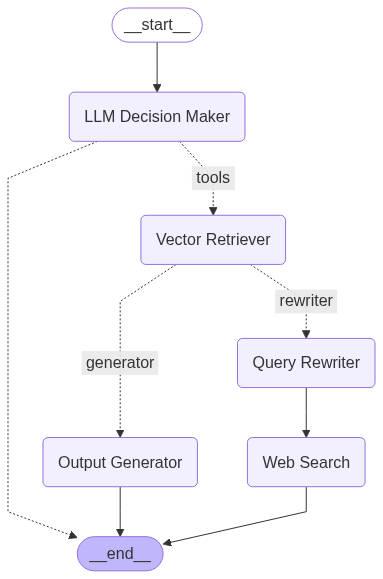

In [30]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents?"]})

----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents?', additional_kwargs={}, response_metadata={}, id='d495ca25-8341-4252-839c-e5f4d906f133'),
  AIMessage(content='LLM Powered Autonomous Agents refer to artificial intelligence systems that utilize Large Language Models (LLMs) to operate autonomously, making decisions and taking actions without human intervention. These agents are designed to perform tasks, reason, and learn from their environment, leveraging the capabilities of LLMs to understand and generate human-like language.\n\nLLM Powered Autonomous Agents can be applied in various domains, such as:\n\n1. Virtual assistants: Autonomous agents can manage tasks, answer questions, and provide recommendations, all while interacting with humans in a natural language.\n2. Robotics: LLMs can be integrated with robotic systems to enable them to understand voice commands, navigate environments, and perform tasks autonomously.\n3. Game playing: Autonomous agents can p

In [36]:
app.invoke({"messages":["who won the ICC trophy this year?"]})

----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='who won the ICC trophy this year?', additional_kwargs={}, response_metadata={}, id='65b71e8c-4b4f-4093-b25c-5904cf460e9e'),
  AIMessage(content="I'm not aware of the current year's ICC trophy winner as my knowledge cutoff is December 2023. For the most up-to-date information, I recommend checking the official ICC website or a reliable sports news source.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 398, 'total_tokens': 443, 'completion_time': 0.163636364, 'prompt_time': 0.028353024, 'queue_time': 0.052969195, 'total_time': 0.191989388}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--e8247b37-7bcb-4e55-8f04-76dbba8543ec-0', usage_metadata={'input_tokens': 398, 'output_tokens': 45, 'total_tokens': 443})]}

In [33]:
app.invoke({"messages":["what is langgraph?"]})

----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='what is langgraph?', additional_kwargs={}, response_metadata={}, id='699a367d-54bb-4815-abb4-90a651005bec'),
  AIMessage(content='LangGraph is an open-source framework for building, training, and deploying large language models (LLMs). It provides a set of tools and libraries to help developers create and fine-tune their own LLMs, with a focus on flexibility, scalability, and ease of use. LangGraph is designed to support a wide range of applications, including natural language processing, text generation, and conversational AI.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 395, 'total_tokens': 477, 'completion_time': 0.364461395, 'prompt_time': 0.021428973, 'queue_time': 0.060512266999999995, 'total_time': 0.385890368}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None}, id='run--bf4cfecc-672c-4f55-82b7-eccf93268a38-0', usage

In [37]:
app.invoke({"messages":["how to create an agent?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE RELEVANT----
----RAG OUTPUT GENERATE----
this is my response:content='To create an agent, you can use a large language model (LLM) as its core controller, as seen in proof-of-concept demos like AutoGPT and GPT-Engineer. The agent system consists of three components: Planning, Memory, and Tool Use, which work together to enable the agent to perform tasks. However, the exact steps to create an agent are not explicitly stated in the provided context.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 375, 'total_tokens': 461, 'completion_time': 0.312727273, 'prompt_time': 0.026119848, 'queue_time': 0.05219821399999999, 'total_time': 0.338847121}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'stop', 'logprobs': None} id='run--e1a6caa7-ddb1-41a6-bfca-0f30937ba07c-0' usage_metadata={'input_tokens

{'messages': [HumanMessage(content='how to create an agent?', additional_kwargs={}, response_metadata={}, id='883aa696-648f-4a7d-94cb-e49937e7b723'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jbjnfwkj3', 'function': {'arguments': '{"query":"creating an agent"}', 'name': 'retriever_blog_post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 396, 'total_tokens': 415, 'completion_time': 0.069090909, 'prompt_time': 0.027368486, 'queue_time': 0.05301615500000001, 'total_time': 0.096459395}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--91abf539-ec91-440d-adab-6327de7206d3-0', tool_calls=[{'name': 'retriever_blog_post', 'args': {'query': 'creating an agent'}, 'id': 'jbjnfwkj3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 396, 'output_tokens': 19, 'total_tokens': 415}),
  ToolMessage(content='Agent System Overview\

In [40]:
app.invoke({"messages":["how to create an agent using Autogen?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE NOT RELEVANT----
----TRANSFORM QUERY----
response from web: [{'title': 'Using AutoGen to build your AI Agents - Microsoft Tech Community', 'url': 'https://techcommunity.microsoft.com/blog/educatordeveloperblog/building-ai-agent-applications-series---using-autogen-to-build-your-ai-agents/4052280', 'content': "The construction of AutoGen is very simple. You only need simple code to quickly configure the agent. By building simple anthropomorphic user agents and assistants, you can complete the construction of a simple agent. Here's how to quickly build a single agent\n\n1. Configuration file, AutoGen. For configuration files, Azure OpenAI Service is generally placed in the AOAI\\_CONFIG\\_LIST in the root directory, such as [...] Everyone knows that I am a Premier League fan. I hope to build an AI agent to help me analyze the situation of each Premier League team in the new season based on t

{'messages': [HumanMessage(content='how to create an agent using Autogen?', additional_kwargs={}, response_metadata={}, id='54dc23f9-2d31-44cd-bbdb-9d62c60e1dd6'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'kjngy7yqj', 'function': {'arguments': '{"query":"creating an agent using Autogen"}', 'name': 'retriever_blog_post'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 399, 'total_tokens': 421, 'completion_time': 0.08, 'prompt_time': 0.023561786, 'queue_time': 0.053129354000000004, 'total_time': 0.103561786}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--54c974ff-de83-4b24-bb7b-cbf35c106762-0', tool_calls=[{'name': 'retriever_blog_post', 'args': {'query': 'creating an agent using Autogen'}, 'id': 'kjngy7yqj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 399, 'output_tokens': 22, 'total_tokens': 421}),
  ToolMes